In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import mlflow
from urllib.parse import urlparse
from mlflow import log_metric, log_param, log_params, log_artifacts
from sklearn import preprocessing
import seaborn as sns 
from wordcloud import WordCloud
import numpy as np
stopword = set(stopwords.words('english')) 
import re
import string
import os

In [43]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/Surbhit01/HateSpeechClassification.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="Surbhit01"
os.environ["MLFLOW_TRACKING_PASSWORD"]="e37df4f3caeed76227a90ce650a87c56d8f03b8e"

mlflow.set_registry_uri = os.environ["MLFLOW_TRACKING_URI"]

In [8]:
datapath = r"Data/labeled_data.csv"

In [9]:
labeled_data = pd.read_csv(datapath,index_col=0)

In [10]:
labeled_data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
labeled_data['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [12]:
labeled_data['class'].value_counts()/labeled_data.shape[0]

class
1    0.774321
2    0.167978
0    0.057701
Name: count, dtype: float64

<Axes: xlabel='class'>

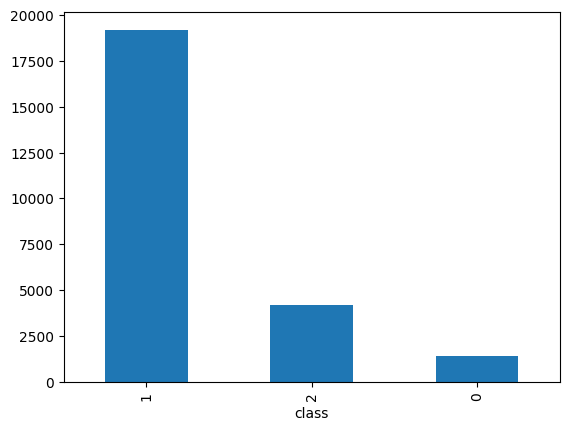

In [13]:
labeled_data['class'].value_counts().plot(kind="bar")

class 0 - Hate Speech <br>
class 1 - Offensive Language <br>
class 2 - No Hate and Offensive <br>

In [14]:
label_map = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "No hate and offensive"
}
labeled_data['label'] = labeled_data['class'].map(label_map)

In [15]:
#Selecting only tweet and data columns
data = labeled_data[['tweet','label']]

In [16]:
data

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,No hate and offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language
...,...,...
25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,Offensive Language
25292,"you've gone and broke the wrong heart baby, an...",No hate and offensive
25294,young buck wanna eat!!.. dat nigguh like I ain...,Offensive Language
25295,youu got wild bitches tellin you lies,Offensive Language


In [17]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    #filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(tweet_tokens)

In [18]:
data['tweet'] = data['tweet'].apply(lambda x: clean(x))

C:\Users\Surbhit Kumar\AppData\Local\Temp\ipykernel_14856\2413313342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet'] = data['tweet'].apply(lambda x: clean(x))


C:\Users\Surbhit Kumar\AppData\Local\Temp\ipykernel_14856\3639522114.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


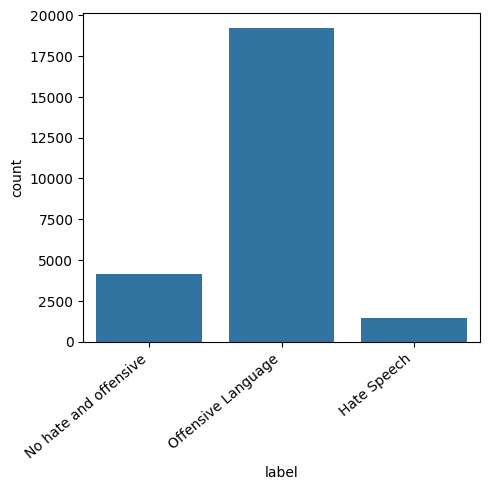

In [19]:
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='label', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

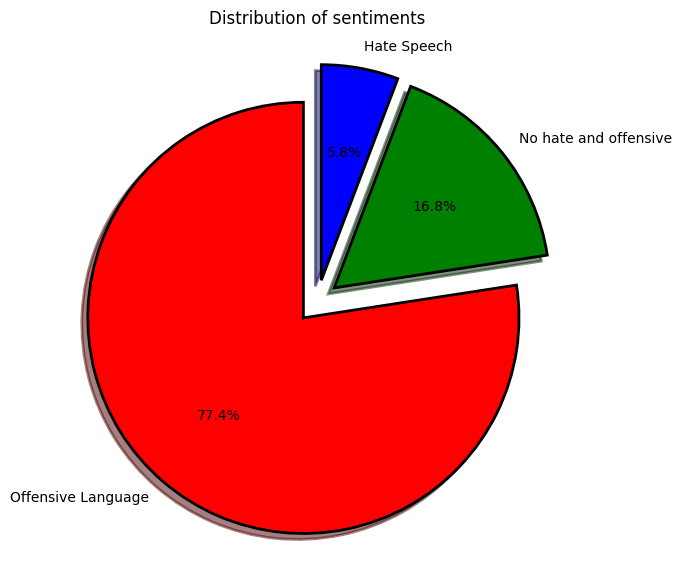

In [20]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = data['label'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

In [21]:
def get_wordcloud(data):
    text = ''.join([word for word in data['tweet']])
    plt.figure(figsize=(20,15),facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1600,height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label=data['label'].values[0], fontsize=19)
    plt.show()

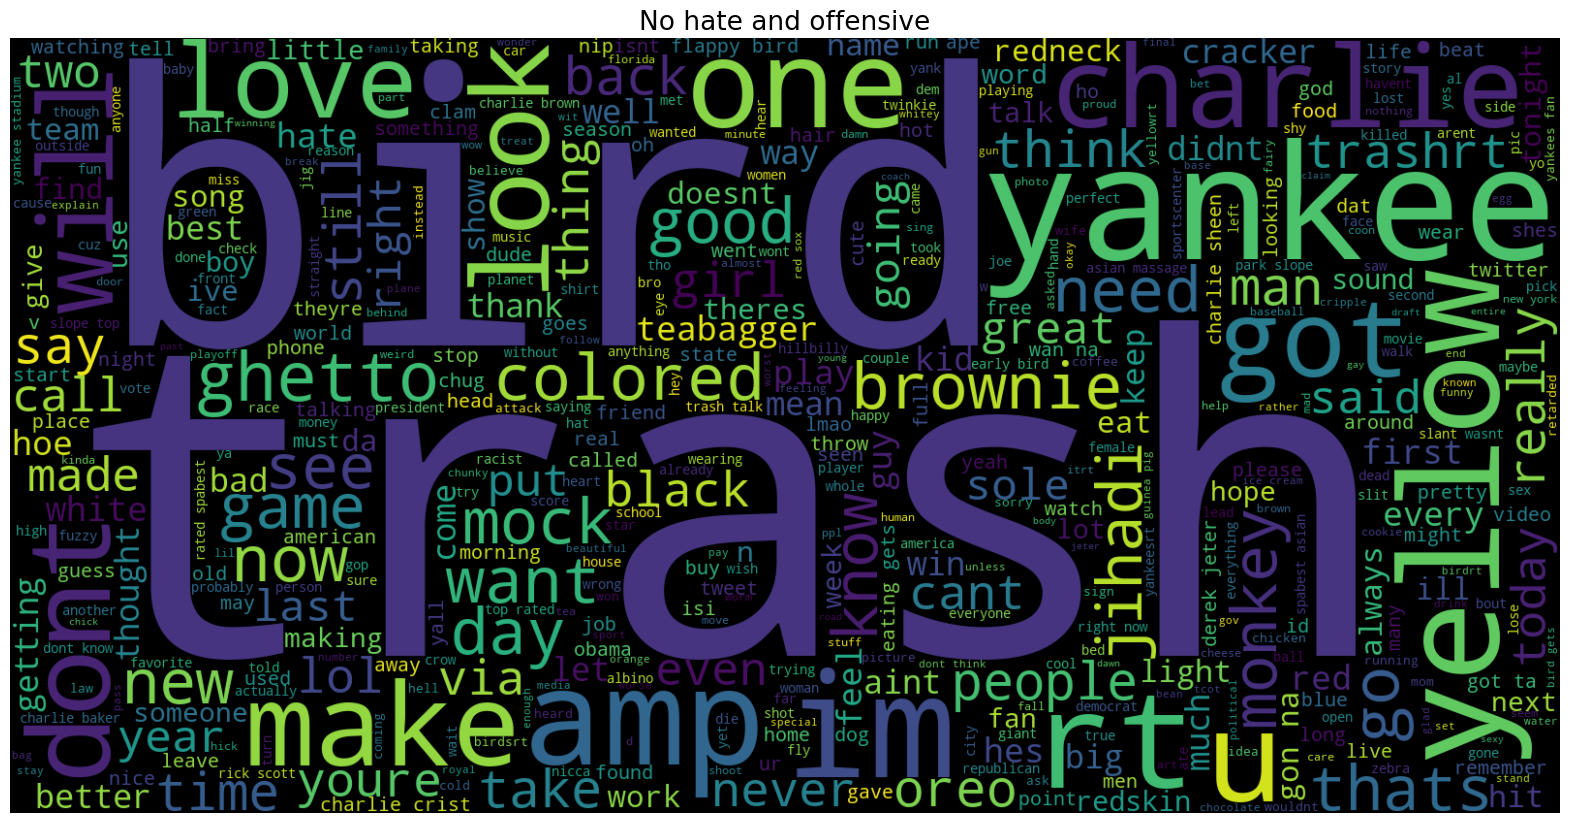

In [22]:
non_hate_tweets = data[data['label']=="No hate and offensive"]
get_wordcloud(non_hate_tweets)

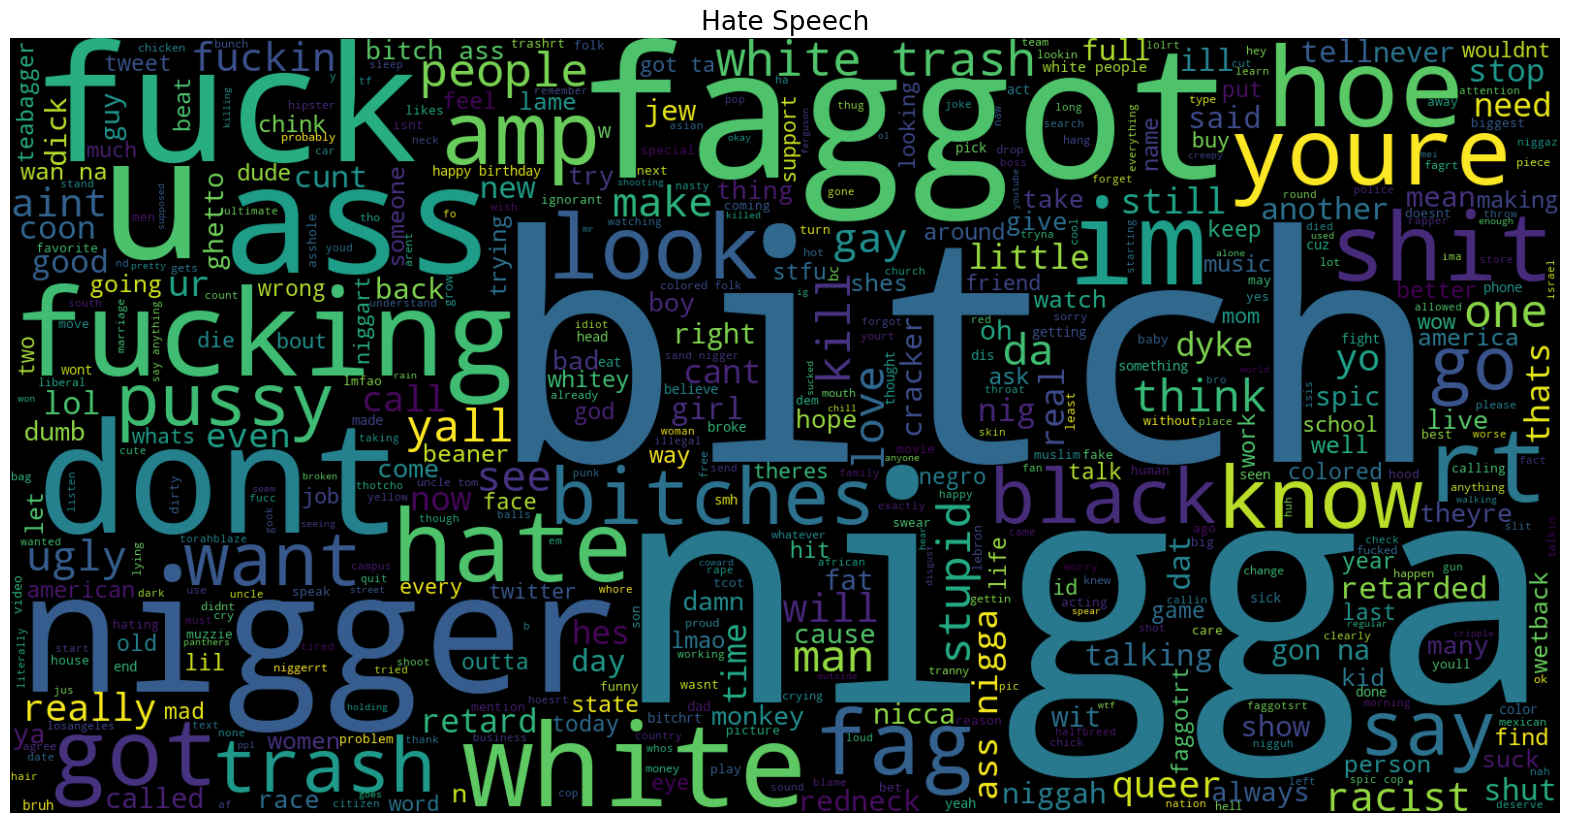

In [23]:
hate_tweets = data[data['label']=="Hate Speech"]
get_wordcloud(hate_tweets)

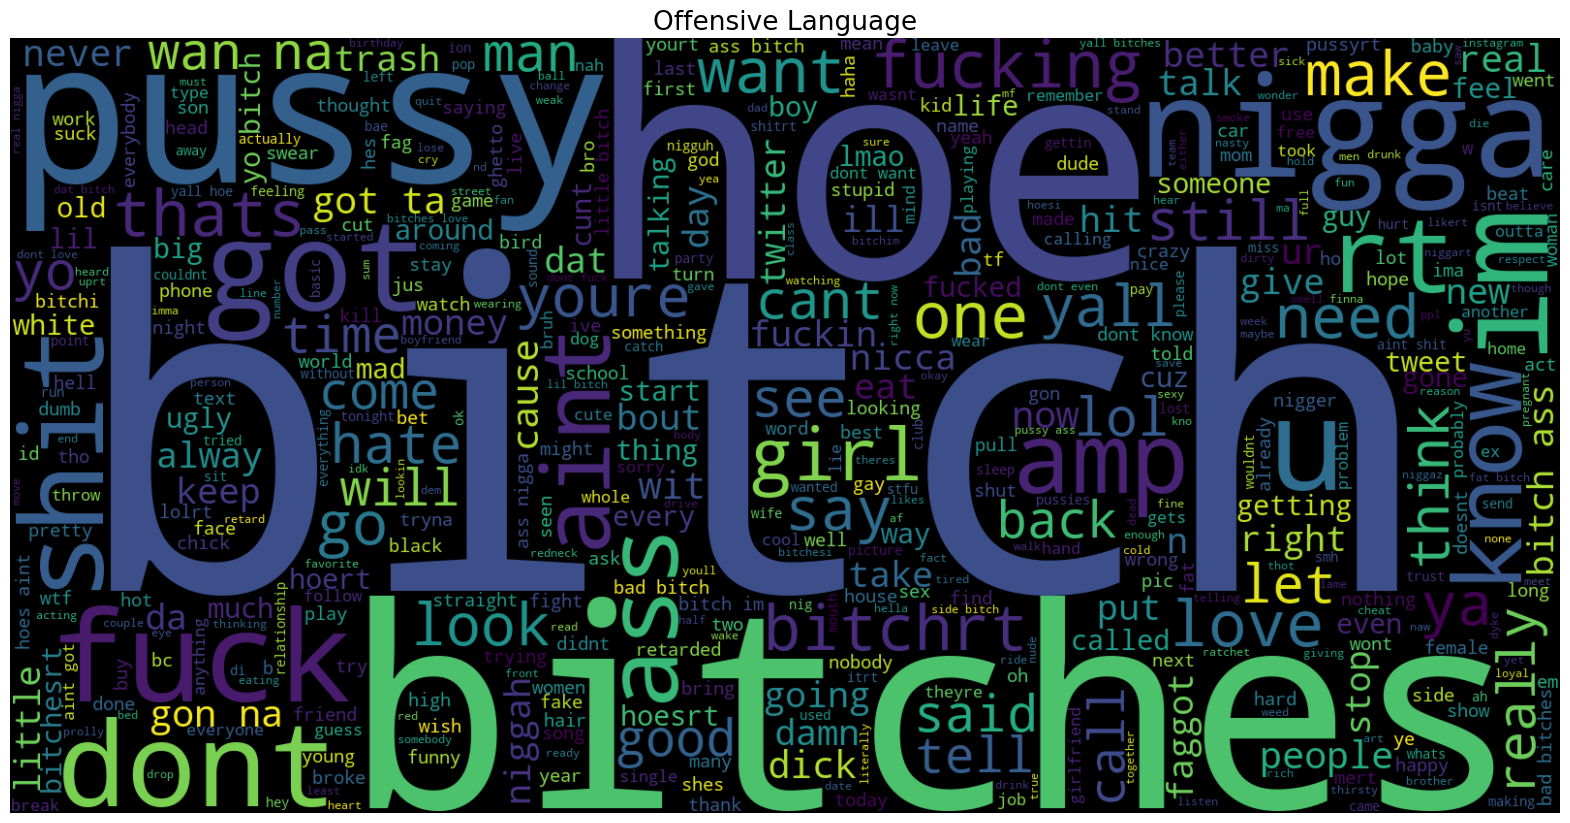

In [24]:
offensive_tweets = data[data['label']=="Offensive Language"]
get_wordcloud(offensive_tweets)

### Modelling

In [26]:
#Dividing into x and y
X = data['tweet']
y = data['label']

In [27]:
#Encoding the output values
encoder = preprocessing.LabelEncoder()
y_enc = encoder.fit_transform(y)

In [28]:
#Train and test split

X_train, X_test, y_train, y_test = train_test_split(X,y_enc,stratify=y,random_state=42,test_size=0.15,shuffle=True)

In [29]:
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (21065,)
Test size: (3718,)


TFIDF

In [30]:
#TFIDF Vectorizer
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                         analyzer='word',
                         token_pattern=r'\w{1,}',
                         ngram_range=(1,3),
                         use_idf=True,
                         smooth_idf=True,
                         sublinear_tf=True)

tfidf.fit(list(X_train)+list(X_test))
X_train_tfidf = tfidf.transform(list(X_train))
X_test_tfidf = tfidf.transform(list(X_test))

LOGISTIC REGRESSION (TFIDF)

In [51]:
exp_name = "Logistic Regression (TFIDF)"

with mlflow.start_run(run_name=exp_name):
    
    model = LogisticRegression(C=1.0)
    model.fit(X_train_tfidf,y_train)
    
    mlflow.log_param("C",1.0)
    
    test_predictions = model.predict(X_test_tfidf)
    train_predictions = model.predict(X_train_tfidf)

    test_accuracy = accuracy_score(y_test,test_predictions)
    train_accuracy = accuracy_score(y_train,train_predictions)
    
    mlflow.log_metric("Test accuracy",test_accuracy*100)
    mlflow.log_metric("Train accuracy",train_accuracy*100)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name=exp_name)
    else:
        mlflow.sklearn.log_model(model, "model")

    print("LOGISTIC REGRESSION (TFIDF) \n\n")
    print("Train accuracy: {:.2f}% \n".format(train_accuracy*100))
    print("Test accuracy: {:.2f}% \n".format(test_accuracy*100))
    print(f"Classification report:\n{classification_report(y_test,test_predictions)}")

d:\Anaconda\envs\hatetext\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnin

LOGISTIC REGRESSION (TFIDF) 


Train accuracy: 93.23% 

Test accuracy: 88.33% 

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.10      0.17       214
           1       0.86      0.74      0.79       625
           2       0.89      0.97      0.93      2879

    accuracy                           0.88      3718
   macro avg       0.78      0.60      0.63      3718
weighted avg       0.87      0.88      0.86      3718



COUNT VECTORIZER

In [52]:
cv = CountVectorizer(analyzer='word',
                     token_pattern=r'\w{1,}',
                     ngram_range=(1,3))

cv.fit(list(X_train)+list(X_test))
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

LOGISTIC REGRESSION (CV)

In [53]:
exp_name = "Logistic Regression (CV)"

with mlflow.start_run(run_name=exp_name):
    
    model = LogisticRegression(C=1.0)
    model.fit(X_train_cv,y_train)
    
    mlflow.log_param("C",1.0)
    
    test_predictions = model.predict(X_test_cv)
    train_predictions = model.predict(X_train_cv)

    test_accuracy = accuracy_score(y_test,test_predictions)
    train_accuracy = accuracy_score(y_train,train_predictions)
    
    mlflow.log_metric("Test accuracy",test_accuracy*100)
    mlflow.log_metric("Train accuracy",train_accuracy*100)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name=exp_name)
    else:
        mlflow.sklearn.log_model(model, "model")

    print("LOGISTIC REGRESSION (CV) \n\n")
    print("Train accuracy: {:.2f}% \n".format(train_accuracy*100))
    print("Test accuracy: {:.2f}% \n".format(test_accuracy*100))
    print(f"Classification report:\n{classification_report(y_test,test_predictions)}")

d:\Anaconda\envs\hatetext\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnin

LOGISTIC REGRESSION (CV) 


Train accuracy: 99.87% 

Test accuracy: 89.35% 

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.17      0.25       214
           1       0.82      0.85      0.84       625
           2       0.92      0.96      0.94      2879

    accuracy                           0.89      3718
   macro avg       0.75      0.66      0.68      3718
weighted avg       0.88      0.89      0.88      3718



NAIVE BAYES (TFIDF)

In [54]:
exp_name = "Naive Bayes (TFIDF)"

with mlflow.start_run(run_name=exp_name):
    
    model = MultinomialNB()
    model.fit(X_train_tfidf,y_train)
    
    test_predictions = model.predict(X_test_tfidf)
    train_predictions = model.predict(X_train_tfidf)

    test_accuracy = accuracy_score(y_test,test_predictions)
    train_accuracy = accuracy_score(y_train,train_predictions)
    
    mlflow.log_metric("Test accuracy",test_accuracy*100)
    mlflow.log_metric("Train accuracy",train_accuracy*100)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name=exp_name)
    else:
        mlflow.sklearn.log_model(model, "model")

    print("NAIVE BAYES (TFIDF) \n\n")
    print("Train accuracy: {:.2f}% \n".format(train_accuracy*100))
    print("Test accuracy: {:.2f}% \n".format(test_accuracy*100))
    print(f"Classification report:\n{classification_report(y_test,test_predictions)}")

d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Naive Bayes (TFIDF)' already exists. Creating a new version of this model...
2023/10/24 01:52:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Naive Bayes (TFIDF), version 2
Created version '2' of model 'Naive Bayes (TFIDF)'.


NAIVE BAYES (TFIDF) 


Train accuracy: 84.04% 

Test accuracy: 82.17% 

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       214
           1       0.93      0.30      0.45       625
           2       0.82      1.00      0.90      2879

    accuracy                           0.82      3718
   macro avg       0.92      0.43      0.45      3718
weighted avg       0.85      0.82      0.77      3718



NAIVE BAYES (CV)

In [55]:
exp_name = "Naive Bayes (CV)"

with mlflow.start_run(run_name=exp_name):
    
    model = MultinomialNB()
    model.fit(X_train_cv,y_train)
    
    test_predictions = model.predict(X_test_cv)
    train_predictions = model.predict(X_train_cv)

    test_accuracy = accuracy_score(y_test,test_predictions)
    train_accuracy = accuracy_score(y_train,train_predictions)
    
    mlflow.log_metric("Test accuracy",test_accuracy*100)
    mlflow.log_metric("Train accuracy",train_accuracy*100)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name=exp_name)
    else:
        mlflow.sklearn.log_model(model, "model")

    print("NAIVE BAYES (CV) \n\n")
    print("Train accuracy: {:.2f}% \n".format(train_accuracy*100))
    print("Test accuracy: {:.2f}% \n".format(test_accuracy*100))
    print(f"Classification report:\n{classification_report(y_test,test_predictions)}")

d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\Anaconda\envs\hatetext\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Naive Bayes (CV)'.
2023/10/24 01:52:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Naive Bayes (CV), version 1
Created version '1' of model 'Naive Bayes (CV)'.


NAIVE BAYES (TFIDF) 


Train accuracy: 97.30% 

Test accuracy: 86.04% 

Classification report:
              precision    recall  f1-score   support

           0       0.32      0.08      0.13       214
           1       0.75      0.72      0.74       625
           2       0.89      0.95      0.92      2879

    accuracy                           0.86      3718
   macro avg       0.66      0.59      0.60      3718
weighted avg       0.84      0.86      0.84      3718

